# Libraries

## I/O

In [1]:
from pprint import pprint
from util_IO import (
    load_pickle_from_main_project_dir,
    EDA_dirs_structure,
    load_attributes_df,
    load_timeseries_df
)

## Analysis

In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

# Settings

## Parameters

### Load metadata from previous step (*1-DataAggregation.ipynb*)

In [3]:
aggr_parameters_dict, camels_gb_use_case_dir = load_pickle_from_main_project_dir(
    'aggr_parameters_dict.pkl'
)

# # Print imported variable
pprint(aggr_parameters_dict)

{'attributes': {'aggregations': {'fundamental': {'chalk_streams_df': ['chalk_stream_flag'],
                                                 'climatic_attributes_df': [],
                                                 'humaninfluence_attributes_df': ['surfacewater_abs',
                                                                                  'groundwater_abs',
                                                                                  'discharges',
                                                                                  'num_reservoir',
                                                                                  'reservoir_cap'],
                                                 'hydrogeology_attributes_df': [],
                                                 'hydrologic_attributes_df': ['baseflow_index'],
                                                 'hydrometry_attributes_df': ['bankfull_flow'],
                                                 'landc

### Retrieve variables in use

In [4]:

camels_gb_data_timeseries_aggr_dir = aggr_parameters_dict['camels_gb_data_timeseries_aggr_dir']
camels_gb_data_attributes_aggr_dir = aggr_parameters_dict['camels_gb_data_attributes_aggr_dir']
date_field = aggr_parameters_dict["timeseries"]["date_field"]
label_field = aggr_parameters_dict["timeseries"]['label_field']
attributes_index = aggr_parameters_dict["attributes"]["attributes_index"]
camels_gb_bronze_dir = aggr_parameters_dict["camels_gb_bronze_dir"]

# Timeseries & attributes

## Create a merge sub data frame

In [5]:
# ___________________________________________
# Define columns for each data frame to merge

# Timeseries
timeseries_columns = [
    date_field,
    'catchmentID',
    f"{date_field}_group",
    'precipitation',
    'temperature',
    'humidity',
    'shortwave_rad',
    'longwave_rad',
    'windspeed',
    label_field
]

# Attributes
attributes_columns = [
    'area',
    'gauge_name'
]


# _________
# Load data

# Timeseries
timeseries_df = load_timeseries_df(
    camels_gb_data_timeseries_aggr_dir,
    "timeseries.csv",
    date_field,
    select_columns=timeseries_columns
)

# Attributes
attributes_df = load_attributes_df(
    camels_gb_data_attributes_aggr_dir,
    "fundamental.csv",
    attributes_index,
    select_columns=attributes_columns
)


# _______________
# Merge & display

# Merge
timeseries_and_attributes_df = (
    timeseries_df
    .merge(
        attributes_df,
        left_on='catchmentID',
        right_index=True,
        how="left"
    )
    .sort_values(
        by=['catchmentID', date_field]
    )
)

# Display
display(timeseries_and_attributes_df.head(3))

,date,catchmentID,date_group,precipitation,temperature,humidity,shortwave_rad,longwave_rad,windspeed,discharge_vol,area,gauge_name
0,1997-03-01,101002,00,0.26,8.31,6.11,73.68,320.09,6.23,0.319,30.61,Medina at Shide
1,1997-03-02,101002,00,0.10,9.55,5.64,89.11,315.49,6.51,0.314,30.61,Medina at Shide
2,1997-03-03,101002,00,24.15,5.84,4.98,51.62,320.09,2.75,0.397,30.61,Medina at Shide


## Rolling on precipitation

In [6]:
# Define rolling windows length
rolling_window_lengths_list = [5, 15, 30]

# Create mean precipitation columns
for rolling_window_length in rolling_window_lengths_list:
    
    timeseries_and_attributes_df[f"precipitation_mean_{rolling_window_length}days"] = (
        timeseries_and_attributes_df.groupby('catchmentID')['precipitation']
            .rolling(
                window=rolling_window_length
            )
            .mean()
            .reset_index(
                drop=True
            )
    )

# Change to `True` if you want to print the data frame visual check
if False:
    timeseries_and_attributes_df.head(max(rolling_window_lengths_list))

## Area vs. Flow chart(s)

In [7]:
# Determine the global min and max values for the precipitation_mean columns
vmin = (
    timeseries_and_attributes_df[[f'precipitation_mean_{w}days' for w in rolling_window_lengths_list]]
        .min()
        .min()
)
vmax = (
    timeseries_and_attributes_df[[f'precipitation_mean_{w}days' for w in rolling_window_lengths_list]]
        .max()
        .max()
)

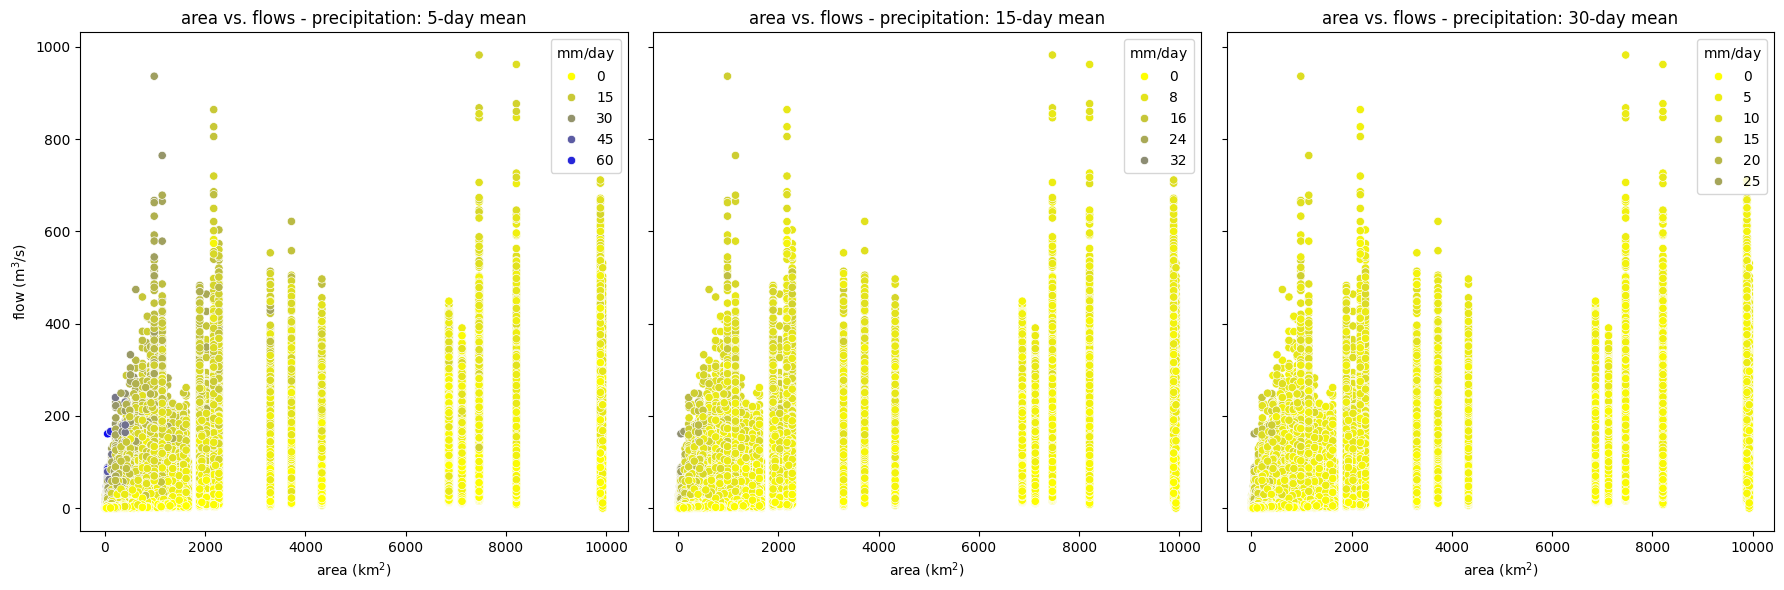

In [8]:
# Create subplots
fig, axes = plt.subplots(
    1,
    len(rolling_window_lengths_list),
    figsize=(18, 6),
    sharex=True,
    sharey=True
)

# Define a custom colormap
cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", ["yellow", "blue"])

for i, window_length in enumerate(rolling_window_lengths_list):
    sns.scatterplot(
        data=timeseries_and_attributes_df.sample(
            frac=1,
            random_state=42
        ),
        x='area',
        y=label_field,
        hue=f"precipitation_mean_{window_length}days",
        ax=axes[i],
        palette=cmap,
        hue_norm=(vmin, vmax)  # Set the same color scale for all subplots
    )
    axes[i].set_title(f"area vs. flows - precipitation: {window_length}-day mean")

    # Add title to the legend
    axes[i].legend(loc='upper right', title=r'$\text{mm/day}$')

    # Set x-axis label with LaTeX
    axes[i].set_xlabel(r'$\text{area (km}^2\text{)}$')

    # Set y-axis label with LaTeX
    axes[i].set_ylabel(r'$\text{flow (m}^3\text{/s)}$')

plt.tight_layout()
plt.show()

#### Zeros checks

Count of the zeros in terms of frequency, consecutive days with zeros, and catchments numerosity

##### `timeseries_zeros_analysis` data frame's creation

##### Load dictionary with time series length

In [9]:
# Load
catchmentID_time_ranges_dict, _ = (
    load_pickle_from_main_project_dir(
        'catchmentID_time_ranges_dict.pkl'
    )
)

# Length calculation
ts_length = (timeseries_and_attributes_df
    .groupby('catchmentID')
    .agg(
        length=('discharge_vol', 'count')
    )
    ['length']
)

##### Zeros count

In [10]:
# Count zeros
timeseries_zeros_count = (
    timeseries_and_attributes_df[
        timeseries_and_attributes_df['discharge_vol'] == 0
    ]
    .groupby('catchmentID')
    .agg(
        area=('area', 'mean'),
        n_of_zeros=('discharge_vol', 'size')
    )
)

# Add the length
timeseries_zeros_count['ts_length'] = ts_length

# Calculate the percentage of zeros
timeseries_zeros_count['%_of_zeros'] = (
    timeseries_zeros_count['n_of_zeros'] / 
        timeseries_zeros_count['ts_length']
)

# Order by higher frequency
timeseries_zeros_count.sort_values(
    by= '%_of_zeros',
    ascending=False,
    inplace=True
)

timeseries_zeros_count_display = timeseries_zeros_count[timeseries_zeros_count['%_of_zeros']>0.03]

display(timeseries_zeros_count_display)
print(timeseries_zeros_count_display.index.to_list())

,area,n_of_zeros,ts_length,%_of_zeros
catchmentID,,,,
41023,86.20,2873,9305,0.308759
39017,21.15,2271,13164,0.172516
39125,62.57,1110,7758,0.143078
39114,90.05,798,7678,0.103933
39120,83.95,539,6893,0.078195
76011,1.63,491,8602,0.057080
26006,8.82,571,12447,0.045875
30014,10.93,401,12036,0.033317


['41023', '39017', '39125', '39114', '39120', '76011', '26006', '30014']
